## 0. Importing Modules

The necessary modules are imported here. Python 3 is used with PyTorch that works with CUDA. Final training is done on Kagle.

In [49]:
import re

import numpy as np              # NumPy, for working with arrays/tensors
import matplotlib.pyplot as plt # For plotting

# PyTorch libraries:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

!pip install torchinfo
from torchinfo import summary

!wget https://github.com/huyvnphan/PyTorch_CIFAR10/archive/refs/tags/v3.0.1.zip
!unzip v3.0.1.zip
!pip install pytorch_lightning
!cp -r PyTorch_CIFAR10-3.0.1/cifar10_models cifar10_models
!python PyTorch_CIFAR10-3.0.1/train.py --download_weights 1
!rm -rf PyTorch_CIFAR10-3.0.1/
!rm -f v3.0.1.zip
!rm -f state_dicts.zip

# For pre-trained ResNet on CIFAR-10
from cifar10_models import resnet

# enable CUDA support if possible
if torch.cuda.is_available():
    print("Cuda (GPU support) is available and enabled!")
    device = torch.device("cuda")
else:
    print("Cuda (GPU support) is not available :(")
    device = torch.device("cpu")

--2021-07-29 10:36:46--  https://github.com/huyvnphan/PyTorch_CIFAR10/archive/refs/tags/v3.0.1.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/huyvnphan/PyTorch_CIFAR10/zip/refs/tags/v3.0.1 [following]
--2021-07-29 10:36:46--  https://codeload.github.com/huyvnphan/PyTorch_CIFAR10/zip/refs/tags/v3.0.1
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v3.0.1.zip’

v3.0.1.zip              [ <=>                ]  21.86K  --.-KB/s    in 0.08s   

2021-07-29 10:36:47 (271 KB/s) - ‘v3.0.1.zip’ saved [22384]

Archive:  v3.0.1.zip
80c232514370d6e9b862eda5f4498588c51fae32
   creating: PyTorch_CIFAR10-3.0.1/
  inflating: PyTorch_CIFAR10

## 1. Image Classification

This part of the implementation deals with reproducing Image Classification related experimental results of the original paper.

### 1.1. Loading the Dataset

For image classification, paper used the ImageNet dataset on training process, but it is a huge dataset in size and number of images. This would increase the training time due to limited computing resources of mine. So, I tried to reproduce the improvements with `CIFAR-10` in the image classification part of experiments. 
Using PyTorch utilities we are able to load the `CIFAR-10` dataset easily, since it is considered a standard dataset for Deep Learning applications.

In [50]:
def load_cifar10():
        """
        Uses torchvision.datasets.ImageNet to load ImageNet.
        Downloads the dataset when necessary.
        Returns 2 datasets for train and validation.
        """
        
        TF = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(31),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        trainset = torchvision.datasets.CIFAR10('./datasets/CIFAR10/', train=True, download=True, transform=TF)
        valset = torchvision.datasets.CIFAR10('./datasets/CIFAR10/', train=False, download=True, transform=TF)

        return trainset, valset 

### 1.2. Define Modified ResNet Models

The paper uses a wider ResNet for the experimental setup on image classification part. It is `4x` wider than the original ResNet implementations. Imitating PyTorch's `2x` wider ResNet implementation I was able to acquire the model. Also, PyTorch Hooks are used to read intermadiate results between blocks.

In general, paper describes layer-wise output matching is achived with appropriately sized linear transformations. But for convolutional layers, these cannot be merged after the process. ResNet output channels are same between layers on reference implementation of PyTorch anyway. So, no linear transformation is needed for this case.

The code below is taken and modified from the ResNet implementation that is trained on CIFAR-10 where needed. The original repo for those networks can be reached from [here](https://github.com/huyvnphan/PyTorch_CIFAR10).

In [51]:
def wide_resnet50_4(**kwargs):
    kwargs['width_per_group'] = 64 * 4
    model = resnet.ResNet(models.resnet.Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

def hook(module, input, output):
    setattr(module, "_value_hook", output)

# Override forward-pass and initialization
class ResNetMod(resnet.ResNet):
    def __init__(self, block, layers, num_classes=10, zero_init_residual=False, group=1, 
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        super(ResNetMod, self).__init__(block, layers, num_classes, zero_init_residual, group, 
                 width_per_group, replace_stride_with_dilation, norm_layer)   
        self.layer_idx = 5
        
    def forward(self, x):
        """
        x: input tensor
        layer_idx: idx of the layer targetted, from 1 to 4
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        if (self.layer_idx >= 1):
            x = self.layer1(x)
            
        if (self.layer_idx >= 2):
            x = self.layer2(x)
        
        if (self.layer_idx >= 3):
            x = self.layer3(x)
        if (self.layer_idx >= 4):
            x = self.layer4(x)
        
        if (self.layer_idx == 5):
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x

def resnetmod50(**kwargs):
    kwargs['width_per_group'] = 64 // 2
    model = ResNetMod(models.resnet.Bottleneck, [3, 4, 6, 3], **kwargs)
    return model

### 1.3. Create ResNet Models

We need to create baseline ResNet50, Wide Teacher ResNet50 and modified ResNet50 for layerwise imitation training. Also, hooks are registered to teacher model to acquire intermediate forward outputs between layers.

For baseline, a pretrained ResNet50 with `1/2` width cannot be found, so student will be check against teacher. But, for ensuring there is no bug and teacher parameters do not get updated, a baseline is also created. To gain time pretrained models are used for teacher and baseline.

In [52]:
teacher = resnet.resnet50(pretrained=True)
student = resnetmod50()
baseline = resnet.resnet50(pretrained=True)

for n, m in teacher.named_modules():
    match = re.search('layer[1234]$', n)
    if match:
        m.register_forward_hook(hook)

In [53]:
print('Teacher')
summary(teacher)

Teacher


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [54]:
print('Student')
summary(student)

Student


Layer (type:depth-idx)                   Param #
ResNetMod                                --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  2,048
│    │    └─BatchNorm2d: 3-2             64
│    │    └─Conv2d: 3-3                  9,216
│    │    └─BatchNorm2d: 3-4             64
│    │    └─Conv2d: 3-5                  8,192
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  8,192
│    │    └─BatchNorm2d: 3-10            64
│    │    └─Conv2d: 3-11                 9,216
│    │    └─BatchNorm2d: 3-12            64
│    │    └─Conv2d: 3-13                 8,192


In [55]:
print('Baseline')
summary(baseline)

Baseline


Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

### 1.4. Training Process

We need to create a training method and apply training using `CIFAR-10` dataset. I made use of `CENG501` assignments for this part.

Batch Normalization decay is `0.9` as a default to my understanding. It is `0.1` as default, but substracted from `1` in the source code. Also, it is phrased as `momentum` in PyTorch.

In [57]:
# epoch assumed to be starting from 0, ending at 89
def vanilla_lr(epoch):
    if (epoch < 5):
        return 0.025 * epoch # linearly increasing from 0 to 0.1 at epochs from 0 to 4
    if (epoch < 29):
        return 0.1
    if (epoch < 59):
        return 0.01  # reduced 10x at 30
    if (epoch < 79):
        return 0.001 # reduced 10x at 60
    return 0.0001    # reduced 10x at 80

def vanilla_train(model, dataloader, multibatch=1, verbose=True):
    """
    Returns: the loss history.
    """
    loss_history = []
    criterion = nn.CrossEntropyLoss()
    for epoch in range(90):
        optimizer = torch.optim.SGD(model.parameters(), lr=vanilla_lr(epoch), momentum=0.9, weight_decay=1e-4)
        for i, data in enumerate(dataloader, 0):    
            print('Training, batch:', i)
            # our batch:
            inputs, truth = data
            inputs = inputs.to(device)
            truth = truth.to(device)

            # zero the gradients as PyTorch accumulates them 
            # every 4 batch since original paper uses batch size of 256
            if (i + 1) % multibatch == 0:
                optimizer.zero_grad()

            # obtain the scores
            outputs = model(inputs)
            # Calculate loss
            loss = criterion(outputs.to(device), truth)

            # backpropagate
            loss.backward()

            # update the weights
            # every 4 batch since original paper uses batch size of 256
            if (i + 1) % multibatch == 0:
                optimizer.step()

            loss_history.append(loss.item())

        if verbose: print(f'Epoch {epoch + 1} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    return loss_history

def train_epoch(model, teacher, criterion, optimizer, dataloader, loss_history, multibatch=1):
    for i, data in enumerate(dataloader, 0):
        if (i + 1) % 100 == 0:
            print('At step: ', i + 1)
        # our batch:
        inputs, _ = data
        inputs = inputs.to(device)
        # No gradient calculation is needed on teacher, reduce memory footprint
        with torch.no_grad():
            truth = teacher(inputs)
            if model.layer_idx < 5:
                for n, m in teacher.named_modules():
                    if n == 'layer' + str(model.layer_idx):
                        truth = m._value_hook
                        break
            truth = truth.cuda(non_blocking=True)
                
        # zero the gradients as PyTorch accumulates them 
        # every 4 batch since original paper uses batch size of 256
        if (i + 1) % multibatch == 0:
            optimizer.zero_grad()

        # obtain the scores
        outputs = model(inputs)
        
        # Calculate loss
        if model.layer_idx < 5:
            loss = criterion(outputs.to(device), truth)
        else:
            loss = criterion(F.log_softmax(outputs.to(device), dim=1), F.log_softmax(truth, dim=1)) # dim=1 since log_prob should be calculated for each batch
        
        # backpropagate
        loss.backward()

        # update the weights
        # every 4 batch since original paper uses batch size of 256
        if (i + 1) % multibatch == 0:
            optimizer.step()

        loss_history.append(loss.item())

def win_train(model, teacher, dataloader, multibatch=1, verbose=True):
    """
    Returns: the loss history
    """
    loss_history = []
    criterion_s1 = nn.MSELoss()
    criterion_s2 = nn.KLDivLoss(reduction='batchmean', log_target=True) # We are converting teacher model output to log probabilities also
    criterion_s3 = nn.CrossEntropyLoss()
    optimizer_s2 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer_s3 = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler_s2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_s2, 4, eta_min=0, last_epoch=-1)
    
    for l in range(4): # for each layer block
        optimizer_s1 = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        scheduler_s1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_s1, 2, eta_min=0, last_epoch=-1)
        model.layer_idx = l + 1
        for epoch in range(2):
            train_epoch(model, teacher, criterion_s1, optimizer_s1, dataloader, loss_history, multibatch=multibatch)
            scheduler_s1.step()
            if verbose: 
                print(f'Epoch {epoch + 1} / {2}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')
    
    model.layer_idx = 5
    
    for epoch in range(4):
        train_epoch(model, teacher, criterion_s2, optimizer_s2, dataloader, loss_history, multibatch=multibatch)
        scheduler_s2.step()
        if verbose: 
            print(f'Epoch {epoch + 1} / {4}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    for epoch in range(4):
        for i, data in enumerate(dataloader, 0):    
            if (i + 1) % 100 == 0:
                print('At step: ', i + 1)
            # our batch:
            inputs, truth = data
            inputs = inputs.to(device)
            truth = truth.to(device)

            # zero the gradients as PyTorch accumulates them 
            # every 4 batch since original paper uses batch size of 256
            if (i + 1) % multibatch == 0:
                optimizer_s3.zero_grad()

            # obtain the scores
            outputs = model(inputs)
            # Calculate loss
            loss = criterion_s3(outputs.to(device), truth)

            # backpropagate
            loss.backward()

            # update the weights
            # every 4 batch since original paper uses batch size of 256
            if (i + 1) % multibatch == 0:
                optimizer_s3.step()

            loss_history.append(loss.item())

        if verbose: 
            print(f'Epoch {epoch + 1} / {4}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

    return loss_history

# batch size used in the paper for Vanilla Training
batch_size = 32
# loaders for datasets
train_dataset, val_dataset = load_cifar10()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
eval_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

model = student.to(device)
teacher = teacher.to(device)
loss_history = win_train(model, teacher, train_loader, multibatch=8)

Files already downloaded and verified
Files already downloaded and verified
At step:  100
At step:  200
At step:  300
At step:  400
At step:  500
At step:  600
At step:  700
At step:  800
At step:  900
At step:  1000
At step:  1100
At step:  1200
At step:  1300
At step:  1400
At step:  1500
Epoch 1 / 1: avg. loss of last 5 iterations 0.0027378831990063192
At step:  100
At step:  200
At step:  300
At step:  400
At step:  500
At step:  600
At step:  700
At step:  800
At step:  900
At step:  1000
At step:  1100
At step:  1200
At step:  1300
At step:  1400
At step:  1500
Epoch 1 / 1: avg. loss of last 5 iterations 0.014877824112772942
At step:  100
At step:  200
At step:  300
At step:  400
At step:  500
At step:  600
At step:  700
At step:  800
At step:  900
At step:  1000
At step:  1100
At step:  1200
At step:  1300
At step:  1400
At step:  1500
Epoch 1 / 1: avg. loss of last 5 iterations 0.06461726576089859
At step:  100
At step:  200
At step:  300
At step:  400
At step:  500
At step:  6

### 1.4. Quantitative Analysis

Again, using the code from the assignments, I plotted the loss function.

Actually longer training times were needed. But, initially a crutual mistake of resizing the input image wrongly to 256 since this ResNet is modified and works with `CIFAR-10` images natively, increased the training time. Since I noticed it late, I had to produce a result at least, despite the training time is shortened with not resizing to 256, remaining time were limited. Still, loss plot clearly indicates layerwise imitation is highly efficient since Kullback-Leibler Divergence stage is observed to be decreasing slower than the first stage.

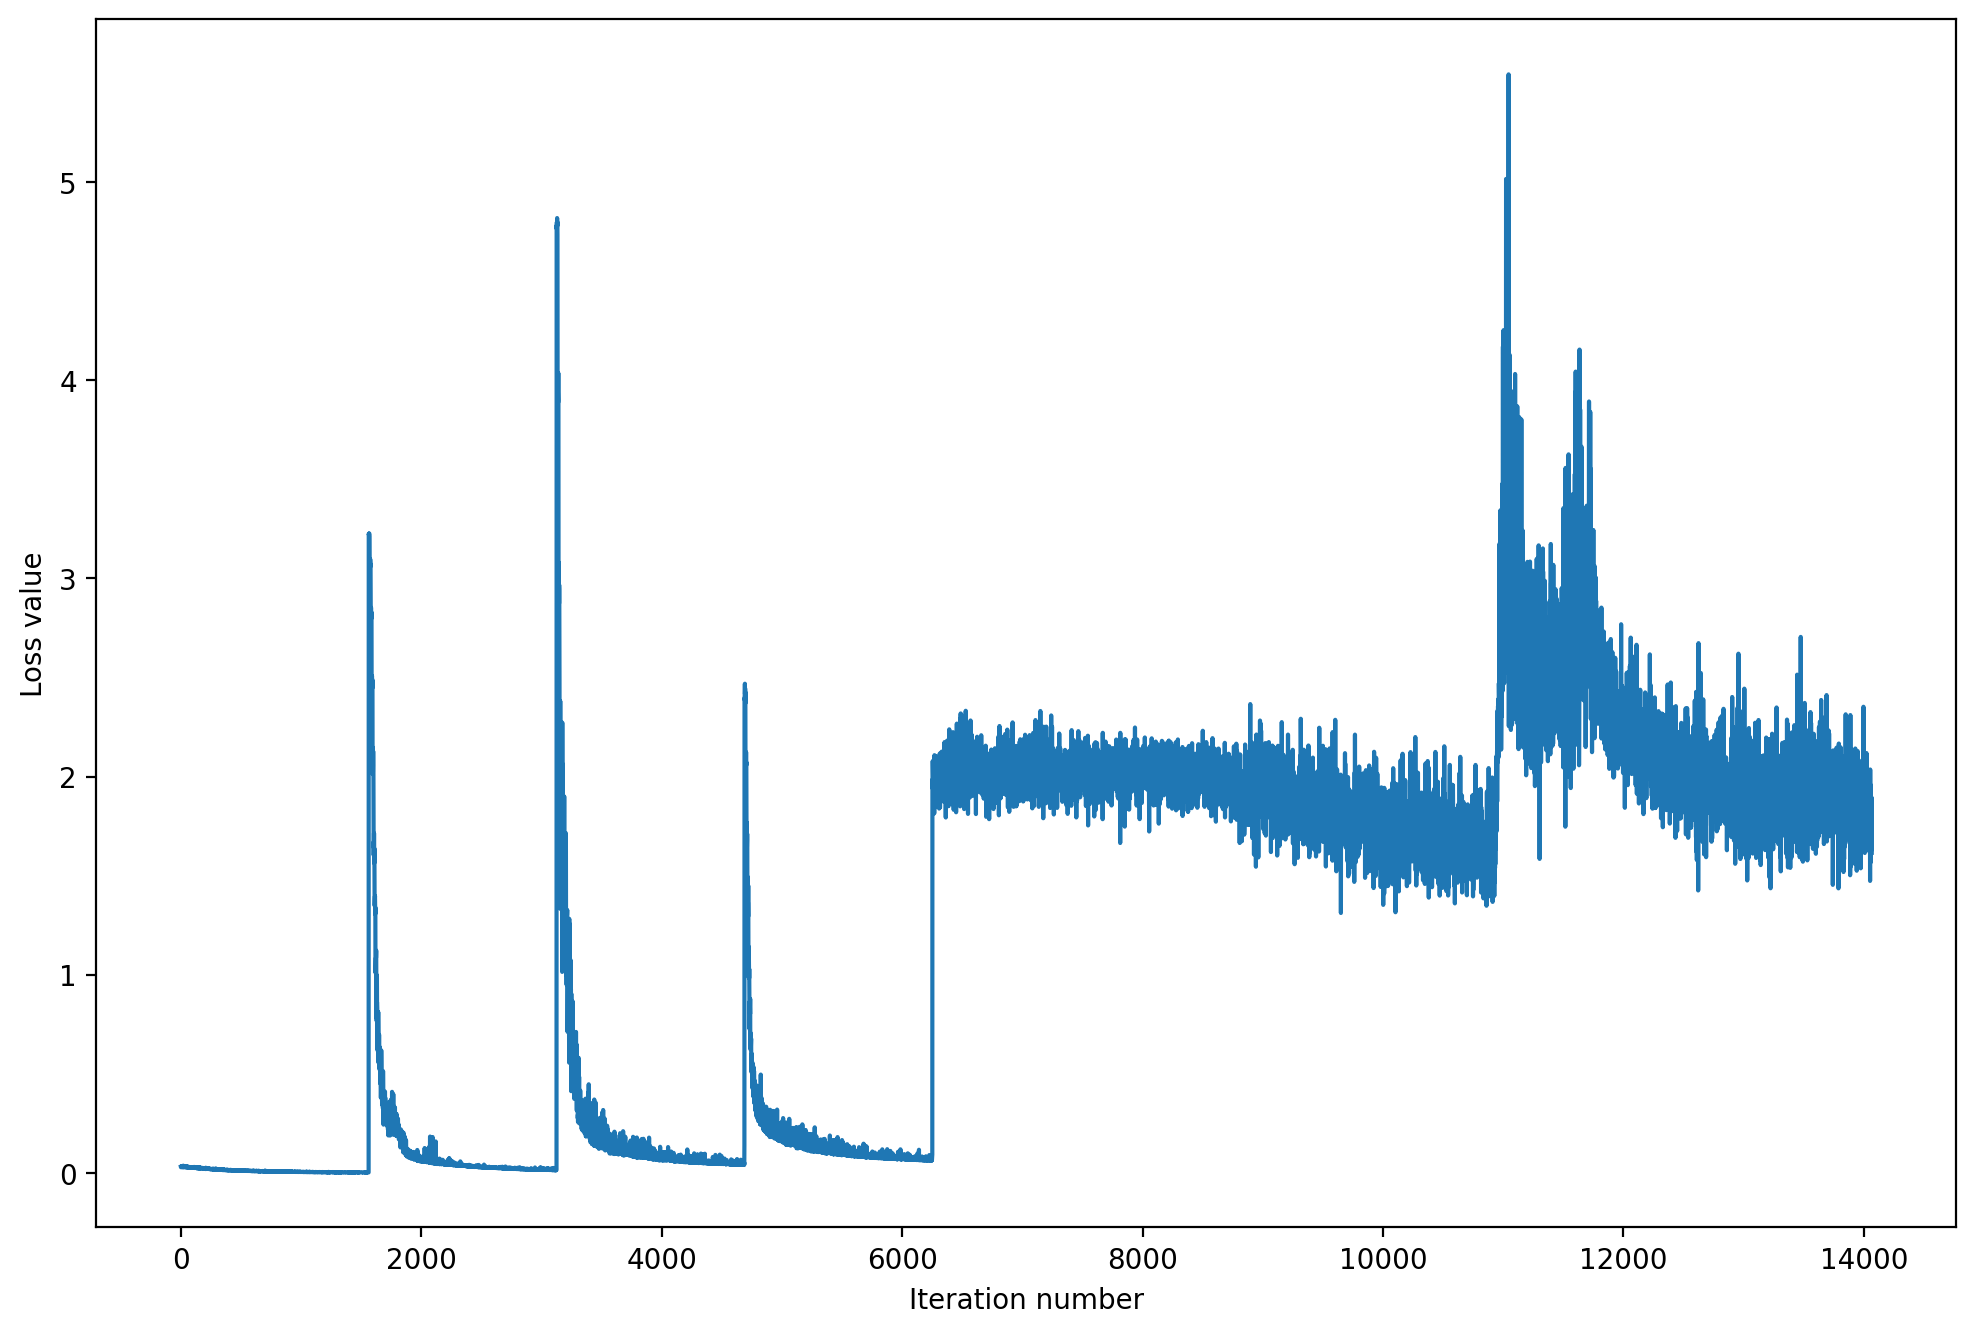

In [58]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 1.5. Accuracy Analysis

Using the code from PAs of the lecture and modifying it slightly I was able to acquire the Top-1 accuracy values.

Unfortunately, accuracy of generated student network is not high enough the draw conclusions. Still, despite 1 epoch per layer, 2 epochs of output imitation and 2 epochs of finetuning is pretty low number of epochs in total for a newly initialized network. And considering the total epoch count, good results are obtained.

There seems to be a small difference between teacher and baseline despite `no_grad` is used for teacher at training. But it is very small difference and could be related to used implementation of ResNet for `CIFAR-10`.

In [59]:
def calc_top1(model, testloader):
    correct = 0
    total = 0

    model = model.to(device)

    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            if (i + 1) % 50 == 0:
                print('Eval at: ', i + 1)
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return (100 * correct / total)

student.eval()
teacher.eval()
baseline.eval()

accuracy_student = calc_top1(student, eval_loader)
print('Accuracy of the student: %d %%' % accuracy_student)
accuracy_teacher = calc_top1(teacher, eval_loader)
print('Accuracy of the teacher: %d %%' % accuracy_teacher)
accuracy_baseline = calc_top1(baseline, eval_loader)
print('Accuracy of the baseline: %d %%' % accuracy_baseline)

Eval at:  50
Eval at:  100
Eval at:  150
Eval at:  200
Eval at:  250
Eval at:  300
Accuracy of the student: 35 %
Eval at:  50
Eval at:  100
Eval at:  150
Eval at:  200
Eval at:  250
Eval at:  300
Accuracy of the teacher: 91 %
Eval at:  50
Eval at:  100
Eval at:  150
Eval at:  200
Eval at:  250
Eval at:  300
Accuracy of the baseline: 92 %
